# Описание проекта

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.
Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.
Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.
В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from plotly import graph_objects as go
import plotly.express as px
from scipy import stats as st
from scipy.stats import norm
import numpy as np
import math as mth
import datetime
import statistics
datetime.datetime.strptime

<function datetime.strptime>

In [2]:
df = pd.read_csv('logs_exp.csv', sep=',', index_col=0)
# df.to_csv('logs_exp.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 9.3+ MB


In [4]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [5]:
df.isna().sum()

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

In [6]:
df.duplicated().sum()

413

In [7]:
df[df.duplicated()]

,EventName,DeviceIDHash,EventTimestamp,ExpId
453,MainScreenAppear,5613408041324010552,1564474784,248
2350,CartScreenAppear,1694940645335807244,1564609899,248
3573,MainScreenAppear,434103746454591587,1564628377,248
4076,MainScreenAppear,3761373764179762633,1564631266,247
4803,MainScreenAppear,2835328739789306622,1564634641,248
...,...,...,...,...
242329,MainScreenAppear,8870358373313968633,1565206004,247
242332,PaymentScreenSuccessful,4718002964983105693,1565206005,247
242360,PaymentScreenSuccessful,2382591782303281935,1565206049,246
242362,CartScreenAppear,2382591782303281935,1565206049,246


In [8]:
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

У нас собраны данные по посещению пользователями мобильного приложения по покупке продуктов питания. Всего собрано 244126 наблюдений, которые собраны по столбцам EventName — название события, DeviceIDHash — уникальный идентификатор пользователя, EventTimestamp — время события, ExpId — номер эксперимента. Пропусков в данных не было. Также существует в наборе данных 413 дубликата, с учетом даты посещения такие дубликаты маловероятны. Стоит их удалить, так как их небольшое количество. 

## Шаг 2. Подготовьте данные

### Замените названия столбцов

In [9]:
df.columns = ['event_name', 'uid', 'event_datetime', 'exp_id']

### Добавьте столбец даты и времени, а также отдельный столбец дат;

In [10]:
df['event_datetime'] = pd.to_datetime(df['event_datetime'], unit='s', origin='unix')
df['event_datetime'] =  pd.to_datetime(df['event_datetime'], infer_datetime_format=True)

In [11]:
df['event_date'] = df['event_datetime'].dt.date

In [12]:
df.head()

,event_name,uid,event_datetime,exp_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


Был совершен перевод даты из формата unix в формат с датой и временем. Также добавлен столбце с датой.

## Шаг 3. Изучите и проверьте данные

### Сколько всего событий в логе?

In [13]:
number_of_logs = df.shape[0]
print('Всего событий в логе:', number_of_logs)

Всего событий в логе: 243713


### Сколько всего пользователей в логе?

In [14]:
number_of_users = df['uid'].nunique()
print('Всего пользователей в логе:', number_of_users)

Всего пользователей в логе: 7551


### Сколько в среднем событий приходится на пользователя?

In [15]:
avg_event_per_user = number_of_logs / number_of_users
print('В среднем на пользователя приходится {:.2f} события.'.format(avg_event_per_user))

В среднем на пользователя приходится 32.28 события.


### Распределение событий

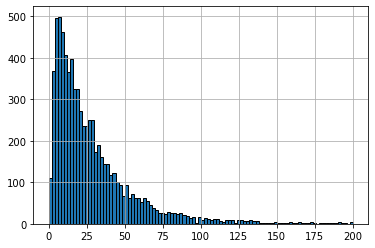

In [16]:
df.groupby('uid')['exp_id'].count().hist(bins=100, range=(0,200), ec='black')
plt.show()


Не буду утверждать, что при данном распределении среднее не точно описывает положение дел. Всё-таки среднее тут тоже подходит.

In [17]:
events_per_users = df['uid'].value_counts()
events_per_users

6304868067479728361    2307
197027893265565660     1998
4623191541214045580    1768
6932517045703054087    1439
1754140665440434215    1221
                       ... 
6888746892508752          1
6671109879025379318       1
1223708690315846789       1
5229230634268921313       1
2408195006658927235       1
Name: uid, Length: 7551, dtype: int64

В наборе данных присутствует 7551 уникальный пользователь. В среднем каждый пользователь совершает 32 действия в данном тестировании. Предполагаю, что этот показатель нормальный, так как прежде чем оформить заказ пользователь обычно просматривает страницы с товарами, совершает сравнение и различные переходы со страницы на страницу. 

### Данными за какой период вы располагаете?

In [18]:
min_data = df['event_datetime'].min()
min_data

Timestamp('2019-07-25 04:43:36')

In [19]:
max_data = df['event_datetime'].max()
max_data

Timestamp('2019-08-07 21:15:17')

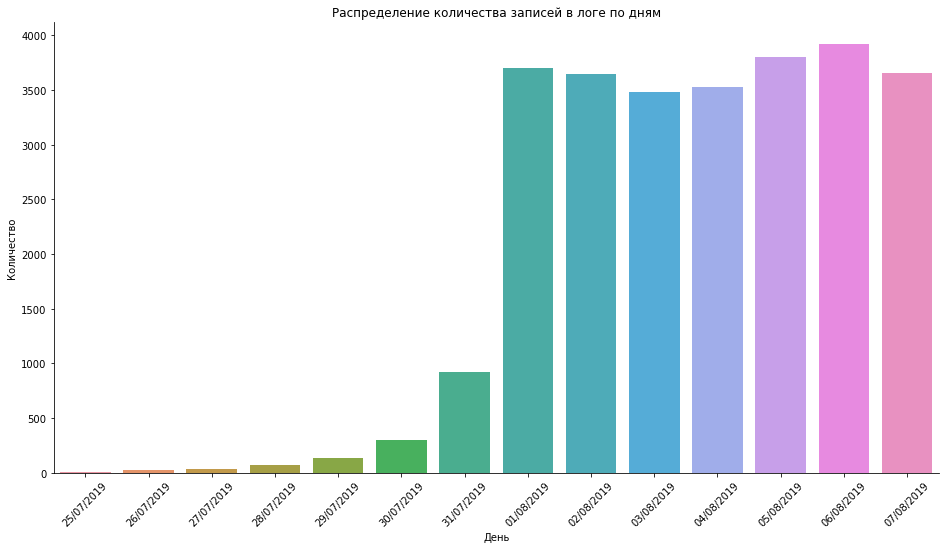

In [20]:
# группируем, чтобы понять сколько пользователей было за период
data_for_period = (df
                   .groupby('event_date')
                   .agg({'uid':'nunique'})
                   .sort_values(by='event_date')
                   .reset_index()
                  )
data_for_period = data_for_period.set_index('event_date')
# Specify datetime frequency
data_for_period = data_for_period.asfreq('D')
data_for_period
 
 
ax = sns.catplot(y='uid', x= 'event_date', kind = 'bar', data=data_for_period.reset_index(), height=7, aspect=2)
(ax
 .set_xticklabels(rotation=45)
 .set_xticklabels(data_for_period.index.strftime("%d/%m/%Y"))
#  .set(xlim=xlim)
 .set(title = 'Распределение количества записей в логе по дням')
 .set(xlabel = 'День')
 .set(ylabel = 'Количество')
)
sns.despine()

Первый вход в приложение совершен 25 июля 2019 года, последний - 07 августа 2019 года. На графике очевидно, что до 01 августа было малое количество, заходивших в приложение. Думаю будет правильнее отфильтровать после даты 01 августа 2019 года. 

### Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?

In [21]:
ts = pd.Timestamp
df_query = df.query('event_datetime >= @ts("20190801T000000")')
df_query

,event_name,uid,event_datetime,exp_id,event_date
2826,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2830,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01
...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
243709,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
243710,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


Удалим более старые данные до 1 августа 2019 года, так как на графике видно, что тестовые пользователи не часто заходили в приложение, что свидетельствует о том, что тестирование началось с 1 августа. Возможно, до 1 августа заходили админы или админы под своими тестовые пользователями. Поэтому брать эти данные не имеет смысла. 

<div class="alert alert-block alert-info">
Окей, отметил себе.
</div>

<hr style="border: 1px solid #000;"> 

### Много ли событий и пользователей вы потеряли, отбросив старые данные?

In [22]:
print('Данные сократились на {} строк.'.format(df.shape[0] - df_query.shape[0]))

Данные сократились на 2826 строк.


In [23]:
number_of_users_df_query = df_query['uid'].nunique()
print('Всего пользователей в логе сокращенного датасета:', number_of_users)
print('Данные сократились на {} уникальных пользователей.'.format(number_of_users - number_of_users_df_query))

Всего пользователей в логе сокращенного датасета: 7551
Данные сократились на 17 уникальных пользователей.


In [24]:
print('Данные сократились на {:.2%} строк.'.format((df.shape[0] - df_query.shape[0]) / df.shape[0]))

Данные сократились на 1.16% строк.


### Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

In [25]:
group_exp_id = (df_query
    .groupby('exp_id')
    .agg({'uid':'nunique'})
    .sort_values(by='uid')
    .reset_index())
group_exp_id

,exp_id,uid
0,246,2484
1,247,2513
2,248,2537


Данные есть во всех 3 экспериментальных группах. В группе 248 бользователей больше всех, что может незначительно ухудшить результаты эксперимента. 

## Шаг 4. Изучите воронку событий

### Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.

In [26]:
df_query['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Наиболее часто пользователи переходят на главный экран приложения. На страницу с какими-то отвечатми на вопросы, FAQ или на отзывы о приложении переходят всего 1005 раз. 

### Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.

In [27]:
number_event = df_query.groupby('event_name').agg({'uid':'nunique'}).sort_values(by='uid', ascending=False).reset_index()
number_event

,event_name,uid
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [28]:
number_event['ratio'] = round(number_event['uid'] / df_query['uid'].nunique(), 3)
number_event

,event_name,uid,ratio
0,MainScreenAppear,7419,0.985
1,OffersScreenAppear,4593,0.610
2,CartScreenAppear,3734,0.496
3,PaymentScreenSuccessful,3539,0.470
4,Tutorial,840,0.111


98,5% пользователей ,что соответсвует 7419 уникальным пользователям переходят на главную страницу. Стоит отметить, что на страницу с оформлением заказа переходят 3734 пользователя, а на страницу с успешной оплатой переходят 3539 пользователей. На это стоит обратить внимание разработчиков, возможно, это связано с ошибками при офрмлении заказа. 

### Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

Можно предположить, что пользователи переходят сначала на главную страницу мобильного приложения. Далее переходят на страницу с предложениями, то есть в выбором товаров, далее переходят в корзину с товарами, после этого польхзователи идут на экран оплаты. Пункт Tutorial может означать какие-то отзывы, FAQ или что-то по оцениванию сервиса. Этот пункт можно убрать из анализа, так как на этот экран могут переходить из разных страниц приложения. 

In [29]:
number_event = number_event.drop(index=[4])
number_event

,event_name,uid,ratio
0,MainScreenAppear,7419,0.985
1,OffersScreenAppear,4593,0.610
2,CartScreenAppear,3734,0.496
3,PaymentScreenSuccessful,3539,0.470


### Рассчитаем без учета последовательности.

In [30]:
fig = go.Figure(go.Funnel(
    y = number_event['event_name'],
    x = number_event['uid'],  textposition = "inside",
    textinfo = "value+percent initial+percent total+percent previous", marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal" ]}))
fig.show()

Если брать расчет без учета последовательности перехода пользователей с этапа на этап, то на экран оформления выбора товаров переходят 62% пользователей - это средний показатель, который можно улучшить. Возможно, пользователям интуитивно не очень понятно куда переходить в каталог товаров. После этого 81% пользователей переходит на экран корзины, что соответствует 50% от первоначального числа пользователей. 95% перешедших в корзину доводят операцию до оплаты товаров, что соответствует 48% от общего количества пользователей.

### Рассчитаем c учетом последовательности.

In [31]:
users = df.pivot_table(
    index='uid', 
    columns='event_name', 
    values='event_datetime',
    aggfunc='min')

step_1 = ~users['MainScreenAppear'].isna()
step_2 = step_1 & (users['OffersScreenAppear'] > users['MainScreenAppear'])
step_3 = step_2 & (users['CartScreenAppear'] > users['OffersScreenAppear'])
step_4 = step_3 & (users['PaymentScreenSuccessful'] > users['CartScreenAppear'])

n_mainscreen = users[step_1].shape[0]
n_offers = users[step_2].shape[0]
n_cart = users[step_3].shape[0]
n_payment = users[step_4].shape[0]

print('Посетителей главного экрана:', n_mainscreen)
print('Переход на экран предложений:', n_offers)
print('Переход в корзину:', n_cart)
print('Переход на экран оплаты:', n_payment)

Посетителей главного экрана: 7439
Переход на экран предложений: 4067
Переход в корзину: 1611
Переход на экран оплаты: 448


In [32]:
d = {'event_name': ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful'], 
     'uid': [n_mainscreen, n_offers, n_cart, n_payment]}
number_event1 = pd.DataFrame(data=d)
number_event1

,event_name,uid
0,MainScreenAppear,7439
1,OffersScreenAppear,4067
2,CartScreenAppear,1611
3,PaymentScreenSuccessful,448


In [33]:
fig = go.Figure(go.Funnel(
    y = number_event1['event_name'],
    x = number_event1['uid'],  textposition = "auto",
    textinfo = "value+percent initial+percent total+percent previous",
    marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal" ]}))
fig.show()

Если брать расчет с учетом последовательности перехода пользователей с этапа на этап, то на экран оформления выбора товаров переходят 55% пользователей. После этого 40% пользователей переходит на экран корзины, что соответствует 22% от первоначального числа пользователей. 28% перешедших в корзину доводят операцию до оплаты товаров, что соответствует 6% от общего количества пользователей.

### На каком шаге теряете больше всего пользователей?

Без учета последовательности перехода с этапа на этап теряется около 38% пользователей. С учетом последовательности перехода с этапа на этап теряется около 45% пользователей. 

<div class="alert alert-block alert-info">
Мы рассчитали воронку продаж без учета того, с какой страницы на какую страницу переходят. Т.е. по моему мнению пользователи могут перейти с главного экрана сразу в корзину, если уже добавляли товар в корзину. 
Также мы сделали ворону к учетом последовательности "Главная страница", "Страница предложения", "Переход в корзину", "Экран успешной оплаты". При разных подходах теряется разное количество пользователей. </div>

### Какая доля пользователей доходит от первого события до оплаты?

Без учета последовательности перехода с этапа на этап до оплаты доходят около 48% пользователей. С учетом последовательности перехода с этапа на этап до оплаты доходят около 6% пользователей. 

## Шаг 5. Изучите результаты эксперимента

### Сколько пользователей в каждой экспериментальной группе?

In [34]:
group_exp_id

,exp_id,uid
0,246,2484
1,247,2513
2,248,2537


В группе 246 находится 2484 пользователей. В группе 247 находится 2513 пользователей. В группе 248 находится 2537 пользователей.

### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.

Выдвинем гипотезы: </br>
H0: доли двух выборок двух генеральных совокупностей равны </br>
H1: доли двух выборок двух генеральных совокупностей различаются </br>

In [35]:
event_list = ['CartScreenAppear', 'MainScreenAppear', 'OffersScreenAppear', 'PaymentScreenSuccessful']
 
def z_test(data1, data2, event):
    
    alpha = 0.05 # критический уровень статистической значимости
    
    # всего пользователей в группе 1 и группе 2
    n_users = np.array([data1['uid'].nunique(), data2['uid'].nunique()]) 
        
    # пользователи, совершившие событие в группу 1 и группе 2
    successes = np.array([data1[data1['event_name'] == event]['uid'].nunique(), 
                          data2[data2['event_name'] == event]['uid'].nunique()])
    
    # пропорция успехов в первой группе:
    p1 = successes[0]/n_users[0]
 
    # пропорция успехов во второй группе:
    p2 = successes[1]/n_users[1]
 
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (n_users[0] + n_users[1])
 
    # разница пропорций в датасетах
    difference = p1 - p2 
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/n_users[0] + 1/n_users[1]))
 
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / n_users[0] + 1 / n_users[1])
    )
 
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение по {}: {}'.format(event, p_value))
 
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

### Статистические критерии разницу между выборками 246 и 247.

In [36]:
for event in event_list:
    z_test(df_query[df_query['exp_id'] == 246], df_query[df_query['exp_id'] == 247], event)

p-значение по CartScreenAppear: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение по MainScreenAppear: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение по OffersScreenAppear: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение по PaymentScreenSuccessful: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Между группами 246 и 247 нет различий в долях параметров. Все p-значения больше 5%, и даже больше 10%, поэтому можем предположить, что эти группы идентичны, соответсвенно, можем продолжать эксперимент дальше.

### Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

In [37]:
g246 = df_query[df_query['exp_id'] == 246]
g247 = df_query[df_query['exp_id'] == 247]
g248 = df_query[df_query['exp_id'] == 248]

g246_grouped = g246.groupby(['exp_id', 'event_name']).agg({'uid':'nunique'}).sort_values(by='uid', ascending=False).reset_index().drop(index=[4])
g247_grouped = g247.groupby(['exp_id', 'event_name']).agg({'uid':'nunique'}).sort_values(by='uid', ascending=False).reset_index().drop(index=[4])
g248_grouped = g248.groupby(['exp_id', 'event_name']).agg({'uid':'nunique'}).sort_values(by='uid', ascending=False).reset_index().drop(index=[4])

In [38]:
g246_grouped['ratio'] = g246_grouped['uid'] / g246_grouped['uid'].sum()
g246_grouped

,exp_id,event_name,uid,ratio
0,246,MainScreenAppear,2450,0.379374
1,246,OffersScreenAppear,1542,0.238774
2,246,CartScreenAppear,1266,0.196036
3,246,PaymentScreenSuccessful,1200,0.185816


In [39]:
g247_grouped['ratio'] = g247_grouped['uid'] / g247_grouped['uid'].sum()
g247_grouped

,exp_id,event_name,uid,ratio
0,247,MainScreenAppear,2476,0.387359
1,247,OffersScreenAppear,1520,0.237797
2,247,CartScreenAppear,1238,0.193680
3,247,PaymentScreenSuccessful,1158,0.181164


In [40]:
g248_grouped['ratio'] = g248_grouped['uid'] / g248_grouped['uid'].sum()
g248_grouped

,exp_id,event_name,uid,ratio
0,248,MainScreenAppear,2493,0.387413
1,248,OffersScreenAppear,1531,0.237918
2,248,CartScreenAppear,1230,0.191142
3,248,PaymentScreenSuccessful,1181,0.183528


### Статистические критерии разницу между выборками 246 и 248.

In [41]:
for event in event_list:
    z_test(df_query[df_query['exp_id'] == 246], df_query[df_query['exp_id'] == 248], event)

p-значение по CartScreenAppear: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение по MainScreenAppear: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение по OffersScreenAppear: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение по PaymentScreenSuccessful: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Между группами 246 и 248 нет различий в долях параметров. Все p-значения больше 5%, однако, для параметра CartScreenAppear  значение меньше 10%, поэтому можем предположить, что эти группы идентичны, соответственно, можем продолжать эксперимент дальше. Стоит отметить, что для параметра CartScreenAppear, возможно, при уровне значимости 10% будет логичным применить изменения в шрифте. 

### Статистические критерии разницу между выборками 247 и 248.

In [42]:
for event in event_list:
    z_test(df_query[df_query['exp_id'] == 247], df_query[df_query['exp_id'] == 248], event)

p-значение по CartScreenAppear: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение по MainScreenAppear: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение по OffersScreenAppear: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение по PaymentScreenSuccessful: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Между группами 247 и 248 нет различий в долях параметров. Все p-значения больше 5%, и даже больше 10%, поэтому можем предположить, что эти группы идентичны, соответственно, можем продолжать эксперимент дальше.

### Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

In [43]:
def z_test (n1, x1, n2, x2, alpha):
    p1 = x1 / n1
    p2 = x2 / n2 
    p = (p1 * n1 + p2 * n2) / (n1 + n2)
    SE = np.sqrt(p * (1 - p) * (1 / n1 + 1 / n2))
    m = SE * norm.ppf(1 - alpha/2)
    z_stat = (p1 - p2) / SE
    p = norm.cdf(np.abs(z_stat))
    return 2 * (1 - p)

In [44]:
# считаем, что 246 и 247 равны
events = df_query.copy()
events['exp_id'] = events['exp_id'].astype(str).str.replace('246|247', 'A').str.replace('248', 'B')
# количество уникальных пользователей 
totals = events.groupby('exp_id').agg({'uid':'nunique'})['uid']
display(totals)
counts = events.pivot_table(index='event_name', columns='exp_id', values='uid', aggfunc='nunique')
# коррекция уровня значимости (по 5 гипотезам в АА и АВ тесте)
counts['alpha'] = 0.05 / (17)
counts['p-value'] = counts.apply(lambda x: z_test(totals['A'], x['A'], totals['B'], x['B'], counts['alpha']), axis=1)
counts

C:\Users\chern\AppData\Local\Temp\ipykernel_12080\1512015339.py:3: FutureWarning:

The default value of regex will change from True to False in a future version.



exp_id
A    4997
B    2537
Name: uid, dtype: int64

exp_id,A,B,alpha,p-value
event_name,,,,
CartScreenAppear,2504,1230,0.002941,0.181759
MainScreenAppear,4926,2493,0.002941,0.294245
OffersScreenAppear,3062,1531,0.002941,0.434255
PaymentScreenSuccessful,2358,1181,0.002941,0.600429
Tutorial,561,279,0.002941,0.764862


В качестве критерия значимости мы выбрали 0,05. Из-за поправок Бонферрони на множественные проверки скорретированный критерий значимости равен 0,05 / 17 =0,00294. При этом ни одна из попарных проверок не дала p-value ниже даже нескорректированного уровня значимости 0,05, т.е. не удалось отвергнуть ни одну нулевую гипотезу. 

### Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

Мы сделали 17 проверок статистических гипотез, 12 проверок между группами 248, 247 и 246 попарно без учета проверки Tutorial. При проверке 246+247 и 248 группы проверялось 5 параметров. Для нашего эксперимента нет смысла менять критерий значимости, так как все значения p-value при всех проверках гипотез намного выше 0,1. 

# Общий вывод

По результатам анализа можно сделать вывод о том, что изменения шрифта не принесет никаких дивидентов. На пользователях это не отразится совсем. Разницы между шрифтами пользователями не будет замечено. Менеджерам стоит приянть решения о том, что шрифты менять не стоит.